In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures
import scipy.stats as stats
%matplotlib inline


def sum_of_square(vec_a, vec_b):
    diff = vec_a - vec_b
    diff_squared = np.square(diff)
    return (np.sum(diff_squared))

def generate_pred_gt_vec(test_ex,x_test_minmax,model,y_test_nn,df_test_for_eval,scaler_minmax):
    # At t
    # x_test_ex: Temperature_at_t Temperature_t-1 Temperature_t-2 pred_temp_t y_gfs_fcst_1

    # At t=t+1
    # x_test_ex: Temperature_t+1 Temperature_t Temperature_t-1 y_gfs_fcst_t y_gfs_fcst_t+1

    pred_list = []
    x_test_ex_arr = np.arange(5.0).reshape(1,5)


    pred_val = model.predict(x_test_minmax)[test_ex]
    pred_list.append(pred_val)

    x_test_dim1_lasttime = df_test_for_eval.ix[test_ex,"Temperature"]
    x_test_dim2_lasttime = df_test_for_eval.ix[test_ex,"Temperature_past1hr"]
    x_test_dim3_lasttime = df_test_for_eval.ix[test_ex,"Temperature_past2hr"]
    x_test_dim4_lasttime = df_test_for_eval.ix[test_ex,"pred_temp"]
    x_test_dim5_lasttime = df_test_for_eval.ix[test_ex,"y_gfs_fcst_1"]

    next_hours = 168 # Next seven days (168 hours)
    for hr in range(1,next_hours):
        hr_t_1 = hr + 1
        col_name_gfs_1 = 'y_gfs_fcst_'+str(hr)
        col_name_gfs_2 = 'y_gfs_fcst_'+str(hr_t_1)

        # prepare test instance the next-hour forecast
        x_test_dim1_current = pred_val
        x_test_dim2_current = x_test_dim1_lasttime
        x_test_dim3_current = x_test_dim2_lasttime
        x_test_dim4_current = df_test_for_eval.ix[test_ex,col_name_gfs_1] 
        x_test_dim5_current = df_test_for_eval.ix[test_ex,col_name_gfs_2] 

        # Populate numpy array
        x_test_ex_arr[0,0] = x_test_dim1_current
        x_test_ex_arr[0,1] = x_test_dim2_current
        x_test_ex_arr[0,2] = x_test_dim3_current
        x_test_ex_arr[0,3] = x_test_dim4_current
        x_test_ex_arr[0,4] = x_test_dim5_current

        # Transform it
        x_test_ex_arr_transformed = scaler_minmax.transform(x_test_ex_arr)

        # Predict and add it to the list
        pred_val = model.predict(x_test_ex_arr_transformed)
        pred_list.append(pred_val)

        # Store current vector
        x_test_dim1_lasttime = x_test_dim1_current
        x_test_dim2_lasttime = x_test_dim2_current
        x_test_dim3_lasttime = x_test_dim3_current
        x_test_dim4_lasttime = x_test_dim4_current
        x_test_dim5_lasttime = x_test_dim5_current

    y_pred_vec = np.asarray(pred_list)
    y_gt_vec = y_test[test_ex,:]
    return y_gt_vec,y_pred_vec

df = pd.read_csv("C:\\Users\\ShaukatAbidi\\Documents\\shaukat_python_progs\\eto_experiment\\data_eto\\gfs_bom_data\\gfs_bom_loc_1.csv")

# Setting UtcTime as the index
df.set_index("Unnamed: 0", inplace=True)

# Dropping variables that are not used for training
df = df.drop('index',axis=1)
df = df.drop('ObservationId',axis=1)
df = df.drop('Timestamp',axis=1)
df = df.drop('ParentLocationId',axis=1)
df = df.drop('RelatedLocationId',axis=1)
df = df.drop('ReadingId',axis=1)
df = df.drop('LocalTime',axis=1)
df = df.drop('TimeZone',axis=1)
df = df.drop('WindDirection',axis=1)
df = df.drop('WindDirectionCompass',axis=1)

# Dropping more variables

# df = df.drop('Temperature',axis=1)
df = df.drop('FeelsLike',axis=1)
df = df.drop('DewPoint',axis=1)
df = df.drop('RelativeHumidity',axis=1)
df = df.drop('Pressure',axis=1)


df = df.drop('WindSpeed',axis=1)
df = df.drop('WindGust',axis=1)
df = df.drop('RainSince9am',axis=1)
df = df.drop('RainfallLastHour',axis=1)
df = df.drop('RainfallLast10Minutes',axis=1)
df = df.drop('pred_cloud_cover',axis=1)
df = df.drop('pred_dewp',axis=1)
df = df.drop('pred_lw_rad',axis=1)
df = df.drop('pred_merid_wind',axis=1)
df = df.drop('pred_pe',axis=1)
df = df.drop('pred_rain_rate',axis=1)
df = df.drop('pred_soil_moisture_lower',axis=1)
df = df.drop('pred_soil_moisture_upper',axis=1)
df = df.drop('pred_sunshine',axis=1)
df = df.drop('pred_surface_pressure',axis=1)
df = df.drop('pred_sw_rad',axis=1)
# df = df.drop('pred_temp',axis=1)
df = df.drop('pred_zonal_wind',axis=1)





# Change units 
df.pred_temp = df.pred_temp - 273.15 # Kelvin to Celsius
# df.pred_dewp = df.pred_dewp - 273.15 # Kelvin to Celsius


In [2]:
print df.columns
print 'Total number of columns = %d' %(len(df.columns))

Index([u'Temperature', u'pred_temp'], dtype='object')
Total number of columns = 2


In [3]:
# Generate df for gt label (Y)
df_gt_output = pd.DataFrame(df.Temperature)

# Rename dataframe for data matrix (X)
df_data = df

In [4]:
# Add temp for the next 7-days
for hrs in range(1,169):
    col_name = 'y_t_'+str(hrs)
    df_gt_output[col_name] = df_gt_output.Temperature.shift(-hrs)
    # print col_name

# Now remove the current temperature from this dataframe
df_gt_output = df_gt_output.drop('Temperature', axis=1)

In [5]:
# df_data.columns
df.columns

Index([u'Temperature', u'pred_temp'], dtype='object')

In [6]:
# Get the observation from past two hours
past_hours = 3

# BOM Temperature for the last two hours
current_col = 'Temperature'
for hr in range(1,past_hours):
    col_name = current_col+'_past'+str(hr)+'hr'
    df_data[col_name] = df[current_col].shift(hr) # Include past values
    print col_name
    
# Add GFS forecasts into the input for the next hour
current_col = 'pred_temp'
next_hours = 169
for hr in range(1,next_hours):
    col_name = 'y_gfs_fcst_'+str(hr)
    df_data[col_name] = df[current_col].shift(-hr) # Include Future Values from GFS
    # print col_name

Temperature_past1hr
Temperature_past2hr


In [7]:
# df_gt_output.head(2)

In [8]:
# df_data.head(5)

In [9]:
new_df = pd.DataFrame()
new_df['Temperature'] = df_data.Temperature
new_df['Temperature_past1hr'] = df_data.Temperature_past1hr
new_df['Temperature_past2hr'] = df_data.Temperature_past2hr
new_df['pred_temp'] = df_data.pred_temp
new_df['y_gfs_fcst_1'] = df_data.y_gfs_fcst_1
# new_df


In [10]:
# df_data.to_csv("C:\\Users\\ShaukatAbidi\\Documents\\shaukat_python_progs\\eto_experiment\\data_eto\\gfs_bom_data\\setting_1\\check_dfdata.csv")
# df_gt_output.to_csv("C:\\Users\\ShaukatAbidi\\Documents\\shaukat_python_progs\\eto_experiment\\data_eto\\gfs_bom_data\\setting_1\\check_df_gt_output.csv")


In [11]:
# df_data

In [12]:
# df_gt_output

In [13]:
len(df_data.columns)

172

In [14]:
tot_cols_df_data = len(df_data.columns)
# Combine data and temp forecast for the next seven days and filter nan
df_combined = pd.concat([df_data,df_gt_output], axis=1)
df_combined = df_combined.dropna()

# Get the list of column names
data_columns = df_combined.columns[0:tot_cols_df_data]
gt_temp_columns = df_combined.columns[tot_cols_df_data:]

# create new dataframe for data and forecast
df_data_nan_filtered = df_combined[data_columns]
df_gt_output_nan_filtered = df_combined[gt_temp_columns]


In [15]:
df_combined.columns[0:tot_cols_df_data]

Index([u'Temperature', u'pred_temp', u'Temperature_past1hr',
       u'Temperature_past2hr', u'y_gfs_fcst_1', u'y_gfs_fcst_2',
       u'y_gfs_fcst_3', u'y_gfs_fcst_4', u'y_gfs_fcst_5', u'y_gfs_fcst_6',
       ...
       u'y_gfs_fcst_159', u'y_gfs_fcst_160', u'y_gfs_fcst_161',
       u'y_gfs_fcst_162', u'y_gfs_fcst_163', u'y_gfs_fcst_164',
       u'y_gfs_fcst_165', u'y_gfs_fcst_166', u'y_gfs_fcst_167',
       u'y_gfs_fcst_168'],
      dtype='object', length=172)

In [16]:
# df_data_nan_filtered

In [17]:
# df_gt_output_nan_filtered

In [18]:
# df_data_nan_filtered.to_csv("C:\\Users\\ShaukatAbidi\\Documents\\shaukat_python_progs\\eto_experiment\\data_eto\\gfs_bom_data\\setting_1\\check_dfdata.csv")
# df_gt_output_nan_filtered.to_csv("C:\\Users\\ShaukatAbidi\\Documents\\shaukat_python_progs\\eto_experiment\\data_eto\\gfs_bom_data\\setting_1\\check_df_gt_output.csv")

In [19]:
df_data_nn = pd.DataFrame()
df_data_nn['Temperature'] = df_data_nan_filtered.Temperature
df_data_nn['Temperature_past1hr'] = df_data_nan_filtered.Temperature_past1hr
df_data_nn['Temperature_past2hr'] = df_data_nan_filtered.Temperature_past2hr
df_data_nn['pred_temp'] = df_data_nan_filtered.pred_temp
df_data_nn['y_gfs_fcst_1'] = df_data_nan_filtered.y_gfs_fcst_1
df_data_nn.head(5)

,Temperature,Temperature_past1hr,Temperature_past2hr,pred_temp,y_gfs_fcst_1
Unnamed: 0,,,,,
2016-06-28 16:00:00,11.5,12.1,12.0,10.283329,10.216659
2016-06-28 17:00:00,11.7,11.5,12.1,10.216659,10.149988
2016-06-28 18:00:00,10.9,11.7,11.5,10.149988,10.016656
2016-06-28 19:00:00,9.8,10.9,11.7,10.016656,9.883325
2016-06-28 20:00:00,9.7,9.8,10.9,9.883325,9.749994


In [20]:
df_data_matrix = df_data_nn.as_matrix()
df_gt_temp_forecast_matrix = df_gt_output_nan_filtered.as_matrix()

In [21]:
print df_data_matrix.shape
print df_gt_temp_forecast_matrix.shape

(4001L, 5L)
(4001L, 168L)


In [22]:
# df_data_nan_filtered.head(3)

In [23]:
# df_gt_output_nan_filtered.head(3)

In [24]:
tot_points = df_data_matrix.shape[0]
train_points = 3000 # training until September
test_points = tot_points - train_points
print(tot_points, train_points, test_points)

(4001L, 3000, 1001L)


In [25]:
# Generate Train Sequence
x_train = df_data_matrix[0:train_points + 1,:]
y_train = df_gt_temp_forecast_matrix[0:train_points + 1,:]
# Generate Test Sequence
x_test = df_data_matrix[train_points + 1:tot_points + 1 ,:]
y_test = df_gt_temp_forecast_matrix[train_points + 1:tot_points + 1 ,:]

print x_train.shape, y_train.shape
print x_test.shape, y_test.shape

(3001L, 5L) (3001L, 168L)
(1000L, 5L) (1000L, 168L)


In [26]:
print y_train.shape

(3001L, 168L)


In [27]:
# y_train[:,0].shape # pass this into the neural network
y_train_nn = np.array(y_train[0:,0:1]).copy()
y_test_nn = np.array(y_test[0:,0:1]).copy()
print y_train_nn.shape, y_test_nn.shape

(3001L, 1L) (1000L, 1L)


In [28]:
print y_test_nn[0:5]

[[ 12.39999962]
 [ 10.30000019]
 [  9.19999981]
 [  8.69999981]
 [  8.5       ]]


In [29]:
# Do scaling according to min-max scaling
scaler_minmax = preprocessing.MinMaxScaler()
x_train = scaler_minmax.fit_transform(x_train)

x_test_minmax = scaler_minmax.transform(x_test)

# Add polynomials
# poly = PolynomialFeatures(degree=2, interaction_only=True)
# x_train = poly.fit_transform(x_train)


In [30]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

Using Theano backend.


In [31]:
print x_train.shape # Training Data (5-feats) for timeseries
print y_train.shape # Training labels for 7-days forecast
print y_train_nn.shape # Training labels for  NN to forecast just one hour ahead
print y_test_nn.shape # Test labels for  NN to forecast just one hour ahead

(3001L, 5L)
(3001L, 168L)
(3001L, 1L)
(1000L, 1L)


In [32]:
# create model
model = Sequential()
model.add(Dense(7000, input_dim=x_train.shape[1], init='normal', activation='relu')) #1st Hidden Layer
model.add(Dense(5000, init='normal', activation='relu')) #2nd Hidden Layer
model.add(Dense(2500, init='normal', activation='relu')) #2nd Hidden Layer
model.add(Dense(1500, init='normal', activation='relu')) #next Hidden Layer
model.add(Dense(1000, init='normal', activation='relu')) #next Hidden Layer
model.add(Dense(500, init='normal', activation='relu')) #next Hidden Layer

model.add(Dense(y_train_nn.shape[1], init='normal')) #output layer
    
# compile model
model.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
# filepath_savemodel = 'C:\\Users\\ShaukatAbidi\\Documents\\shaukat_python_progs\\learning\\time_series\\feed_forward_nn\\models\\weights.{epoch:02d}-{val_loss:.2f}.h5'
filepath_savemodel = 'C:\\Users\\ShaukatAbidi\\Documents\\shaukat_python_progs\\learning\\time_series\\feed_forward_nn\\models\\s8_callback\\weights_s8.h5'
filepath_csvlogger = 'C:\\Users\\ShaukatAbidi\\Documents\\shaukat_python_progs\\learning\\time_series\\feed_forward_nn\\models\\s8_callback\\training_s8.log'

checkpointer = ModelCheckpoint(filepath_savemodel, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='auto')
csv_logger = CSVLogger(filepath_csvlogger, separator=',', append=False)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, mode='auto', epsilon=0.0001, cooldown=0, min_lr=0.001)

history = model.fit(x_train, y_train_nn, nb_epoch=1000, verbose=1, validation_data=(x_test_minmax, y_test_nn), batch_size = 32, shuffle=True, callbacks=[checkpointer, csv_logger, reduce_lr])

Train on 3001 samples, validate on 1000 samples
Epoch 1/1000
3001/3001 [==============================] - 53s - loss: 10.6719 - val_loss: 2.7017
Epoch 2/1000
3001/3001 [==============================] - 53s - loss: 0.7487 - val_loss: 0.5344
Epoch 3/1000
3001/3001 [==============================] - 52s - loss: 0.6118 - val_loss: 0.4843
Epoch 4/1000
3001/3001 [==============================] - 52s - loss: 0.6316 - val_loss: 0.6524
Epoch 5/1000
3001/3001 [==============================] - 53s - loss: 0.6039 - val_loss: 0.5059
Epoch 6/1000
3001/3001 [==============================] - 63s - loss: 0.6822 - val_loss: 2.9334
Epoch 7/1000
3001/3001 [==============================] - 85s - loss: 0.7889 - val_loss: 0.4927
Epoch 8/1000
3001/3001 [==============================] - 194s - loss: 0.5922 - val_loss: 0.4842
Epoch 9/1000
3001/3001 [==============================] - 292s - loss: 0.8845 - val_loss: 0.5374
Epoch 10/1000
3001/3001 [==============================] - 226s - loss: 0.6339 - val_

In [84]:
print history.history.keys()
print history.history['loss']
print history.history['val_loss']
# dir(history.model.model)

['loss', 'val_loss']
[0.56454798498776548, 0.52872976125458482, 0.55604120402763546, 0.54302149641636965, 0.62315250176940107]
[0.47140777707099912, 0.4838961944580078, 0.5681805939674377, 0.44132849752902986, 1.6891033582687378]


<bound method History.on_batch_begin of <keras.callbacks.History object at 0x0000000016749400>>

In [34]:
# model.save('C:\\Users\\ShaukatAbidi\\Documents\\shaukat_python_progs\\learning\\time_series\\feed_forward_nn\\models\\model_s7.h5')
# from keras.models import load_model
# model = load_model('C:\\Users\\ShaukatAbidi\\Documents\\shaukat_python_progs\\learning\\time_series\\feed_forward_nn\\models\\model_s7.h5')

In [35]:
print 'train_points: ',train_points,'test_points: ',test_points,'tot_points: ',tot_points

# Generate Train DF
df_train_for_eval = df_data_nan_filtered.iloc[0:train_points + 1,:]

# Generate Test DF
df_test_for_eval = df_data_nan_filtered.iloc[train_points + 1:tot_points + 1 ,:]


train_points:  3000 test_points:  1001 tot_points:  4001


In [38]:
df_train_for_eval

,Temperature,pred_temp,Temperature_past1hr,Temperature_past2hr,y_gfs_fcst_1,y_gfs_fcst_2,y_gfs_fcst_3,y_gfs_fcst_4,y_gfs_fcst_5,y_gfs_fcst_6,...,y_gfs_fcst_159,y_gfs_fcst_160,y_gfs_fcst_161,y_gfs_fcst_162,y_gfs_fcst_163,y_gfs_fcst_164,y_gfs_fcst_165,y_gfs_fcst_166,y_gfs_fcst_167,y_gfs_fcst_168
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
2016-06-28 16:00:00,11.500000,10.283329,12.100000,12.000000,10.216659,10.149988,10.016656,9.883325,9.749994,10.083327,...,9.516656,9.383325,9.249994,9.049992,8.849990,8.649988,8.483321,8.316654,8.149988,8.016656
2016-06-28 17:00:00,11.700000,10.216659,11.500000,12.100000,10.149988,10.016656,9.883325,9.749994,10.083327,10.416661,...,9.383325,9.249994,9.049992,8.849990,8.649988,8.483321,8.316654,8.149988,8.016656,7.883325
2016-06-28 18:00:00,10.900000,10.149988,11.700000,11.500000,10.016656,9.883325,9.749994,10.083327,10.416661,10.749994,...,9.249994,9.049992,8.849990,8.649988,8.483321,8.316654,8.149988,8.016656,7.883325,7.749994
2016-06-28 19:00:00,9.800000,10.016656,10.900000,11.700000,9.883325,9.749994,10.083327,10.416661,10.749994,11.683333,...,9.049992,8.849990,8.649988,8.483321,8.316654,8.149988,8.016656,7.883325,7.749994,7.716659
2016-06-28 20:00:00,9.700000,9.883325,9.800000,10.900000,9.749994,10.083327,10.416661,10.749994,11.683333,12.616673,...,8.849990,8.649988,8.483321,8.316654,8.149988,8.016656,7.883325,7.749994,7.716659,7.683323
2016-06-28 21:00:00,9.300000,9.749994,9.700000,9.800000,10.083327,10.416661,10.749994,11.683333,12.616673,13.550012,...,8.649988,8.483321,8.316654,8.149988,8.016656,7.883325,7.749994,7.716659,7.683323,7.649988
2016-06-28 22:00:00,10.400000,10.083327,9.300000,9.700000,10.416661,10.749994,11.683333,12.616673,13.550012,12.750004,...,8.483321,8.316654,8.149988,8.016656,7.883325,7.749994,7.716659,7.683323,7.649988,7.883325
2016-06-28 23:00:00,10.600000,10.416661,10.400000,9.300000,10.749994,11.683333,12.616673,13.550012,12.750004,11.949996,...,8.316654,8.149988,8.016656,7.883325,7.749994,7.716659,7.683323,7.649988,7.883325,8.116663
2016-06-29 00:00:00,11.600000,10.749994,10.600000,10.400000,11.683333,12.616673,13.550012,12.750004,11.949996,11.149988,...,8.149988,8.016656,7.883325,7.749994,7.716659,7.683323,7.649988,7.883325,8.116663,8.350000


In [39]:
df_test_for_eval

,Temperature,pred_temp,Temperature_past1hr,Temperature_past2hr,y_gfs_fcst_1,y_gfs_fcst_2,y_gfs_fcst_3,y_gfs_fcst_4,y_gfs_fcst_5,y_gfs_fcst_6,...,y_gfs_fcst_159,y_gfs_fcst_160,y_gfs_fcst_161,y_gfs_fcst_162,y_gfs_fcst_163,y_gfs_fcst_164,y_gfs_fcst_165,y_gfs_fcst_166,y_gfs_fcst_167,y_gfs_fcst_168
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
2016-10-21 06:00:00,13.700000,13.439996,13.700000,14.500000,11.669997,9.899998,8.129999,7.869999,7.610000,7.350000,...,11.159998,10.023330,9.833885,8.886662,8.697217,7.749994,7.761106,7.816665,7.883335,7.950006
2016-10-21 07:00:00,12.400000,11.669997,13.700000,13.700000,9.899998,8.129999,7.869999,7.610000,7.350000,7.311112,...,10.023330,9.833885,8.886662,8.697217,7.749994,7.761106,7.816665,7.883335,7.950006,7.855561
2016-10-21 08:00:00,10.300000,9.899998,12.400000,13.700000,8.129999,7.869999,7.610000,7.350000,7.311112,7.116673,...,9.833885,8.886662,8.697217,7.749994,7.761106,7.816665,7.883335,7.950006,7.855561,7.383335
2016-10-21 09:00:00,9.200000,8.129999,10.300000,12.400000,7.869999,7.610000,7.350000,7.311112,7.116673,6.883346,...,8.886662,8.697217,7.749994,7.761106,7.816665,7.883335,7.950006,7.855561,7.383335,6.816665
2016-10-21 10:00:00,8.700000,7.869999,9.200000,10.300000,7.610000,7.350000,7.311112,7.116673,6.883346,6.650018,...,8.697217,7.749994,7.761106,7.816665,7.883335,7.950006,7.855561,7.383335,6.816665,6.249994
2016-10-21 11:00:00,8.500000,7.610000,8.700000,9.200000,7.350000,7.311112,7.116673,6.883346,6.650018,6.516677,...,7.749994,7.761106,7.816665,7.883335,7.950006,7.855561,7.383335,6.816665,6.249994,6.949996
2016-10-21 12:00:00,8.242857,7.350000,8.500000,8.700000,7.311112,7.116673,6.883346,6.650018,6.516677,6.383335,...,7.761106,7.816665,7.883335,7.950006,7.855561,7.383335,6.816665,6.249994,6.949996,7.649998
2016-10-21 12:10:00,8.200000,7.311112,8.242857,8.500000,7.116673,6.883346,6.650018,6.516677,6.383335,6.249994,...,7.816665,7.883335,7.950006,7.855561,7.383335,6.816665,6.249994,6.949996,7.649998,7.766665
2016-10-21 13:00:00,8.100000,7.116673,8.200000,8.242857,6.883346,6.650018,6.516677,6.383335,6.249994,6.550002,...,7.883335,7.950006,7.855561,7.383335,6.816665,6.249994,6.949996,7.649998,7.766665,8.350000


In [40]:
test_ex = 0
pred_list = []

x_test_ex = x_test_minmax[test_ex,:]
pred_val = model.predict(x_test_minmax)[test_ex]
pred_list.append(pred_val)

print 'x_test_instance: ',x_test_ex
print 'gt: ', y_test_nn[test_ex],'pred: ', pred_val

# print df_test_for_eval.ix[test_ex,"y_gfs_fcst_2"]
next_hours = 168
for hr in range(1,next_hours):
    col_name = 'y_gfs_fcst_'+str(hr)
    # print df_test_for_eval.ix[test_ex,col_name]

x_test_dim1 = df_test_for_eval.ix[test_ex,"Temperature"]
x_test_dim2 = df_test_for_eval.ix[test_ex,"Temperature_past1hr"]
x_test_dim3 = df_test_for_eval.ix[test_ex,"Temperature_past2hr"]
x_test_dim4 = df_test_for_eval.ix[test_ex,"pred_temp"]
x_test_dim5 = df_test_for_eval.ix[test_ex,"y_gfs_fcst_1"]

x_test_ex_arr = np.arange(5.0).reshape(1,5)
x_test_ex_arr[0,0] = x_test_dim1
x_test_ex_arr[0,1] = x_test_dim2
x_test_ex_arr[0,2] = x_test_dim3
x_test_ex_arr[0,3] = x_test_dim4
x_test_ex_arr[0,4] = x_test_dim5

print 'x_test_instance_before_transformation',x_test_ex_arr
x_test_ex_arr_transformed = scaler_minmax.transform(x_test_ex_arr)
print 'x_test_instance_after_transformation',x_test_ex_arr_transformed
print 'prediction on transformed x_test ',model.predict(x_test_ex_arr_transformed)
# x_test_ex: Temperature Temperature_past1hr Temperature_past2hr pred_temp y_gfs_fcst_1

x_test_instance:  [ 0.54741377  0.54741377  0.58189653  0.57634774  0.50290381]
gt:  [ 12.39999962] pred:  [-0.17403169]
x_test_instance_before_transformation [[ 13.69999981  13.69999981  14.5         13.43999634  11.66999715]]
x_test_instance_after_transformation [[ 0.54741377  0.54741377  0.58189653  0.57634774  0.50290381]]
prediction on transformed x_test  [[-0.17403179]]


x_test_instance:  [ 0.512931    0.50862066  0.4827586   0.59886933  0.64370547]
gt:  [ 12.30000019] pred:  [ 13.69102001]


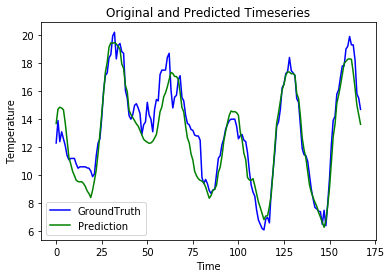

In [39]:
# At t
# x_test_ex: Temperature_at_t Temperature_t-1 Temperature_t-2 pred_temp_t y_gfs_fcst_1

# At t=t+1
# x_test_ex: Temperature_t+1 Temperature_t Temperature_t-1 y_gfs_fcst_t y_gfs_fcst_t+1

test_ex = 87
pred_list = []
x_test_ex_arr = np.arange(5.0).reshape(1,5)


x_test_ex = x_test_minmax[test_ex,:]
pred_val = model.predict(x_test_minmax)[test_ex]
pred_list.append(pred_val)

print 'x_test_instance: ',x_test_ex
print 'gt: ', y_test_nn[test_ex],'pred: ', pred_val

x_test_dim1_lasttime = df_test_for_eval.ix[test_ex,"Temperature"]
x_test_dim2_lasttime = df_test_for_eval.ix[test_ex,"Temperature_past1hr"]
x_test_dim3_lasttime = df_test_for_eval.ix[test_ex,"Temperature_past2hr"]
x_test_dim4_lasttime = df_test_for_eval.ix[test_ex,"pred_temp"]
x_test_dim5_lasttime = df_test_for_eval.ix[test_ex,"y_gfs_fcst_1"]

next_hours = 168 # Next seven days (168 hours)
for hr in range(1,next_hours):
    hr_t_1 = hr + 1
    col_name_gfs_1 = 'y_gfs_fcst_'+str(hr)
    col_name_gfs_2 = 'y_gfs_fcst_'+str(hr_t_1)
    
    # prepare test instance the next-hour forecast
    x_test_dim1_current = pred_val
    x_test_dim2_current = x_test_dim1_lasttime
    x_test_dim3_current = x_test_dim2_lasttime
    x_test_dim4_current = df_test_for_eval.ix[test_ex,col_name_gfs_1] 
    x_test_dim5_current = df_test_for_eval.ix[test_ex,col_name_gfs_2] 
    
    # Populate numpy array
    x_test_ex_arr[0,0] = x_test_dim1_current
    x_test_ex_arr[0,1] = x_test_dim2_current
    x_test_ex_arr[0,2] = x_test_dim3_current
    x_test_ex_arr[0,3] = x_test_dim4_current
    x_test_ex_arr[0,4] = x_test_dim5_current
    
    # Transform it
    x_test_ex_arr_transformed = scaler_minmax.transform(x_test_ex_arr)
    
    # Predict and add it to the list
    pred_val = model.predict(x_test_ex_arr_transformed)
    pred_list.append(pred_val)

    # Store current vector
    x_test_dim1_lasttime = x_test_dim1_current
    x_test_dim2_lasttime = x_test_dim2_current
    x_test_dim3_lasttime = x_test_dim3_current
    x_test_dim4_lasttime = x_test_dim4_current
    x_test_dim5_lasttime = x_test_dim5_current
    
y_pred_vec = np.asarray(pred_list)
y_gt_vec = y_test[test_ex,:] 

# print y_pred_vec.shape, y_gt_vec.shape

# plot
time_index = np.arange(0,168,1)
plt.plot(time_index,y_gt_vec,label="GroundTruth",color='b')
plt.plot(time_index,y_pred_vec,label="Prediction",color='g')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.legend()
plt.title('Original and Predicted Timeseries')

In [39]:
plt.scatter(y_gt_vec,y_pred_vec)
plt.xlabel('Groundtruth')
plt.ylabel('Prediction')
plt.title('Groundtruth vs Prediction')